# Inteligencia Artificial

# Clase 23 - Modelos generativos 2
## Autoencoders

En esta clase seguiremos explorando algunas alternativas de arquitecturas de redes neuronales capaces de generar contenido "original". En este caso trabajaremos con autoencoders para generar imágenes de rostros, a partir de un conocido dataset, el cual pueden obtener ejecutando la celda siguiente.

!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

### El dataset

Trabajaremos con el dataset **CelebA**, cuyo sitio oficial es http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

Aquí encontraremos 202599 imágenes de rostros de celebridades en distintas versiones. Por practicidad, trabajaremos con la versión que ofrece las imágenes ya centradas, enderezadas y cropeadas para que le sea más fácil a la red aprender qué es un rostro.

El dataset cuenta con archivos adicionales en los que hay información agregada sobre cada imágen. Nos será de particular interés el archivo que contiene atributos de las imágenes.

In [0]:
import os
import pandas as pd

notebook_dir = os.getcwd()
faces_dir = os.path.join(notebook_dir, "data_faces/img_align_celeba")
attrs_file = os.path.join(notebook_dir, "list_attr_celeba.txt")

Carguemos el archivo con los atributos para ver qué contiene.

In [0]:
attrs_df = pd.read_csv(attrs_file, delim_whitespace=True, skiprows=1)

In [0]:
attrs_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


Como vemos, cada columna es una variable dummy que indica la presencia (+1) o ausencia (-1) de dicho atributo.

Pasemos ahora a inspeccionar las imágenes.

In [0]:
n_images = len(os.listdir(faces_dir))
n_images

202599

In [0]:
os.listdir(faces_dir)[:10]

['105222.jpg',
 '083302.jpg',
 '095653.jpg',
 '009865.jpg',
 '004042.jpg',
 '116294.jpg',
 '151527.jpg',
 '161766.jpg',
 '013770.jpg',
 '110589.jpg']

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

Definimos una función auxiliar que dado el nombre de una imágen, devuelve qué atributos tiene.

In [0]:
def get_attrs(filename):
    row = attrs_df.loc[filename, :]
    return [attr for attr in row.index if row[attr]==1]

In [0]:
get_attrs(os.listdir(faces_dir)[0])

['Bags_Under_Eyes',
 'Big_Nose',
 'Chubby',
 'Double_Chin',
 'Goatee',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Receding_Hairline',
 'Smiling']

Usando la función definida previamente, graficaremos algunas imágenes de muestra junto con los primeros 5 atributos que tenga.

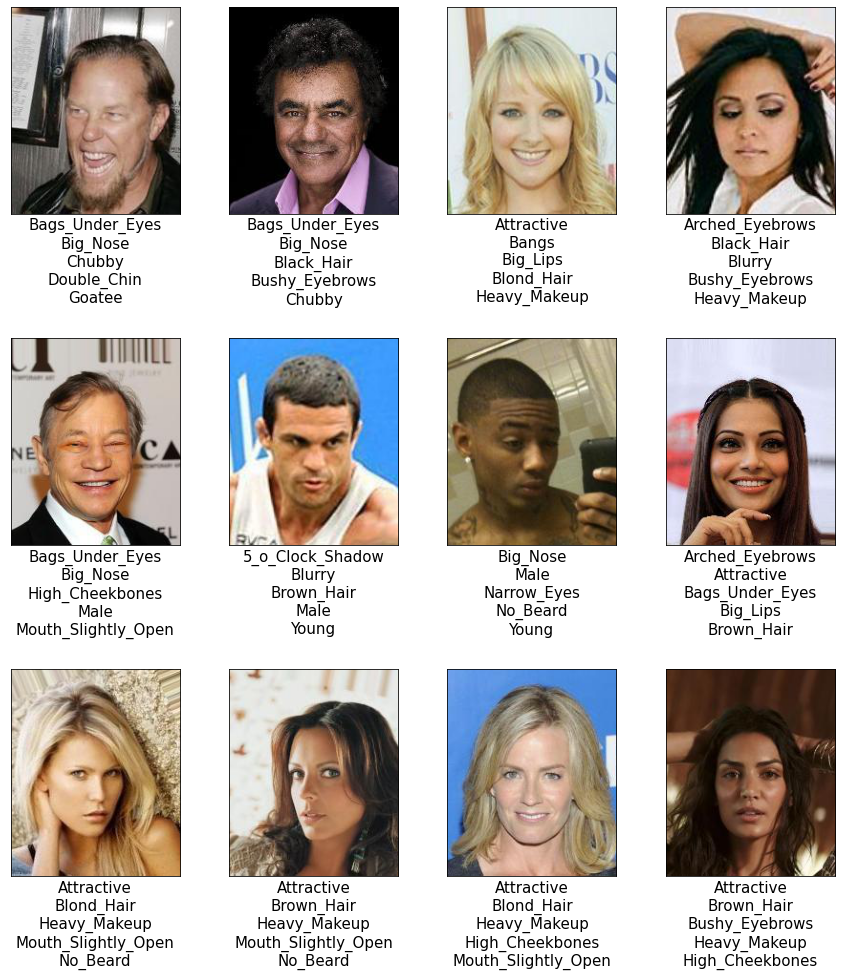

In [0]:
fig, axes = plt.subplots(3, 4, figsize=(15,16))
fig.subplots_adjust(hspace=0.6)
for i, ax in enumerate(axes.flatten()):
    filename = os.listdir(faces_dir)[i]
    img = plt.imread(os.path.join(faces_dir, filename))
    ax.imshow(img)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.set_xlabel("\n".join(get_attrs(filename)[:5]), fontsize=15)

Ahora construiremos un generador que nos permita obtener dinámicamente batches de imágenes que se encuentren en la carpeta en la que descomprimimos el dataset.

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Realizaremos dos operaciones de preprocesamiento de las imágenes:
- reescalado de las imágenes para llevar el valor de cada píxel al rango [0,1], siendo esta la operación de normalización del dataset.
- resizing para que las imágenes se ajusten a las dimensiones esperadas por la red.

In [0]:
data_gen = ImageDataGenerator(rescale=1./255)

In [0]:
batch_size=128
data_flow = data_gen.flow_from_directory(os.path.join(faces_dir,os.pardir), 
                                         class_mode="input", 
                                         subset="training",
                                         batch_size=batch_size,
                                         target_size=(128,128)                         
                                        )

Found 202599 images belonging to 1 classes.


## El modelo

Ahora construiremos el autoencoder, que consta de dos redes diferentes:
- el encoder
- el decoder

Importemos los módulos necesarios para definir la estructura de ambas redes.


In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Activation, BatchNormalization
import tensorflow.keras.backend as K
import numpy as np

### Encoder

Partiremos de una imagen con tamaño de entrada (128 x 128) y 3 canales de profundidad (RGB), tal como le especificamos al generador.

In [0]:
encoder_input = Input(shape=(128,128,3), name='encoder_input')

Como estamos trabajando con imágenes, utilizaremos capas convolucionales para aprender filtros que permitan identificar y extraer características de las imágenes. Luego aplanaremos el tensor tridimensional para conectarlo con una capa densa que genere la representación intermedia de la imagen codificada. Esta arquitectura corresponde a la utilizada en libro *Generative Deep Learning* de David Foster.

In [0]:
conv_layer_0 = Conv2D(
                filters = 32,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_0')
x = conv_layer_0(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_layer_1 = Conv2D(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_1')
x = conv_layer_1(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_layer_2 = Conv2D(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_2')
x = conv_layer_2(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_layer_3 = Conv2D(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_3')
x = conv_layer_3(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]
print(f"Antes de aplanar, el tensor tiene forma {K.int_shape(x)}")

x = Flatten()(x)

# Definimos la dimensión de salida del encoder
encoder_output = Dense(200, name="encoder_output")(x)

# Armamos el Model del encoder
encoder = Model(encoder_input, encoder_output, name="encoder")

Antes de aplanar, el tensor tiene forma (None, 8, 8, 64)


In [0]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0   

### Decoder

El trabajo del decoder es partir de una imágen codificada en un espacio latente de baja dimensionalidad y entregar una imagen reconstruida que sea lo más parecida posible a la original.

Así como para reducir el alto y ancho de las imágenes y sus representaciones intermedias utilizamos convoluciones definiendo un _stride_, un _padding_ y un tamaño de _kernel_, para **incrementar** el tamaño de las representaciones intermedias para volver al alto y ancho original utilizaremos una operación llamada _convolución traspuesta_ (mal llamada deconvolución en mucha bibliografía).

Esta operación puede visualizarse gráficamente de la siguiente forma:

<img src=http://images2.programmersought.com/358/22/22abaad2f90f81d4a55bcd72c858b2de.JPEG>

Donde en celeste tenemos los píxeles de la imágen original, separados por un determinado _stride_ y con un determinado _padding_ alrededor; en gris tenemos la superficia afectada por el kernel para generar el píxel de la imágen resultante en verde.

Este concepto de convolución transpuesta tiene su origen en que una convolución puede escribirse como un producto matricial entre la imágen original aplanada y una matriz C con la forma 

<img src=http://images3.programmersought.com/609/d9/d973c2b8e874402a6408bb2bb97e73c9.png>

(para un kernel de 3x3 aplicado a una imágen de 4x4)

Si una imagen A de 4x4 la escribimos como un vector X de 16x1, podemos escribir $A*k$ como $C·X$, donde C es de 4x16. El resultado será un vector Y de 4x1, pudiendo reescribirlo como una imágen B de 2x2. Obtenemos el mismo resultado que convolucionando.

Si ahora hacemos la operación inversa, es decir, aplanamos B para que sea un vector Y de 4x1, lo multiplicamos con la _traspuesta_ de C, obtenemos como resultado $C^T·Y=X$ de 16x1, que lo podemos reescribir como una matriz de 4x4.

Utilizaremos estas capas para formar una imágen con las mismas dimensiones del input, a partir de su representación intermedia en el espacio latente.

In [0]:
decoder_input = Input(shape=(200,), name="decoder_input")

# Debemos reconstruir el camino inverso del encoder
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

# Expandimos el ancho y alto del volumen usando Conv2DTranspose
conv_t_layer = Conv2DTranspose(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t_0'
                )
x = conv_t_layer(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_t_layer = Conv2DTranspose(
                filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t_1'
                )
x = conv_t_layer(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

conv_t_layer = Conv2DTranspose(
                filters = 32,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t_2'
                )
x = conv_t_layer(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Volvemos a llevar la imagen reconstruida a 3 canales 
conv_t_layer = Conv2DTranspose(
                filters = 3,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'decoder_conv_t3'
                )
x = conv_t_layer(x)

# En este caso necesitamos que la salida esté entre 0 y 1
decoder_output = Activation("sigmoid")(x)

decoder = Model(decoder_input, decoder_output, name="decoder")

In [0]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              823296    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 32, 32, 64)        3692

### Modelo completo

El modelo completo consiste en la concatenación del encoder con el decoder.

In [0]:
# El input del modelo, es el input del encoder
model_input = encoder_input
# El output del modelo, es el output del decoder cuando recibe la salida del encoder
model_output = decoder(encoder_output)
# El modelo completo va de punta a punta
autoencoder = Model(model_input, model_output, name="Autoencoder")

In [0]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        

In [0]:
autoencoder.compile("adam", loss="mse")

In [0]:
autoencoder.fit(data_flow,
                steps_per_epoch=int(n_images/batch_size),
                epochs=5 #50
                )
autoencoder.save_weights("autoencoder_weights.h5")

Epoch 1/5
1582/1582 [==============================] - 164s 104ms/step - loss: 0.0057
Epoch 2/5
1582/1582 [==============================] - 164s 104ms/step - loss: 0.0057
Epoch 3/5
1582/1582 [==============================] - 164s 104ms/step - loss: 0.0057
Epoch 4/5
1582/1582 [==============================] - 165s 104ms/step - loss: 0.0057
Epoch 5/5
1582/1582 [==============================] - 165s 104ms/step - loss: 0.0057


### Evaluación del modelo

Para evaluar el modelo, sólo debemos tomar una imágen, codificarla usando el encoder y luego reconstruirla usando el decoder. Esto es equivalente a correr el modelo completo de punta a punta.

Utilzaremos OpenCV para realizar algunas operaciones auxiliares con las imágenes.

In [0]:
import cv2

Primero obtendremos una imágen de muestra tomada al azar.

In [0]:
# Elegimos un archivo al azar
sample_file = attrs_df.sample().index[0]
# Cargamos la imagen usando OpenCV
img = cv2.imread(os.path.join(faces_dir,sample_file))
# Debemos invertir el orden de los canales
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape

(218, 178, 3)

In [0]:
# Hacemos un resizing para que las dimensiones sean las esperadas por la red
input_image = cv2.resize(img, (128,128))
input_image.shape

(128, 128, 3)

In [0]:
# A diferencia de otras bibliotecas para el manejo de imágenes, 
# OpenCV guarda la información de cada imágen en un array de numpy
type(input_image)

numpy.ndarray

In [0]:
# Reescalamos la imágen y agregamos la dimensión del batch para que sea el input del modelo
output_image = autoencoder(np.expand_dims(input_image/255, axis=0))
output_image.shape

TensorShape([1, 128, 128, 3])

In [0]:
# Volvemos a hacer resizing al tamaño original
reconstructed_image = cv2.resize(output_image[0].numpy(), (178,218))
reconstructed_image.shape

(218, 178, 3)

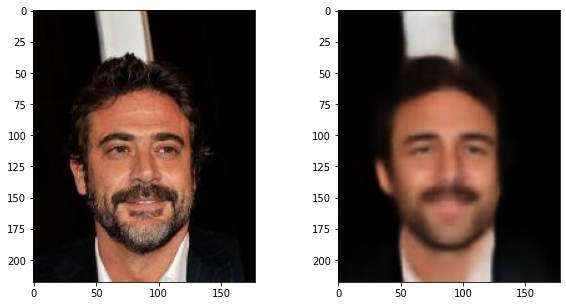

In [0]:
# Comparamos las imágenes
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(reconstructed_image)

### Generando imágenes nuevas

Para que un modelo generativo sea considerado exitoso debe cumplir 2 requisitos:
- Las imágenes generadas deben parecer como si hubieran sido extraídas del dataset de entrenamiento
- Las imágenes generadas deben diferer de las imágenes presentes en el dataset de entrenamiento.

Es decir, que las imágenes generadas sean parecidas pero no iguales a las ya conocidas. 

Podemos hacer que un modelo generativo sea muy fiel respecto a la calidad de las imágenes si hacemos que replique a la perfección las imágenes de entrenamiento, pero eso dejaría mucho que desear desde el punto de vista de la generación de nuevo contenido.

Si en el otro extremo, generamos imágenes completamente nuevas y diferentes a las ya conocidas, pero éstas ya no son reconocibles como caras, el modelo generativo fracasó.

Para evaluar la capacidad de generar nuevas imágenes, tenemos que tomar una muestra aleatoria del espacio latente y decodificarla usando la red entrenada para obtener una imágen original.

Analicemos la distribución de las imágenes del dataset en el espacio de representaciones.

In [0]:
from tqdm import tqdm

In [0]:
data_flow.batch_index = 0
representaciones = np.zeros((n_images, 200))
for i in tqdm(range(len(data_flow))):
    next_data = data_flow.next()[0]
    representaciones[i*data_flow.batch_size:i*data_flow.batch_size+next_data.shape[0]] = encoder(next_data)

100%|██████████| 1583/1583 [02:41<00:00,  9.78it/s]


In [0]:
maximos = representaciones.max(axis=0)
minimos = representaciones.min(axis=0)

Ahora que conocemos los límites para cada dimensión, tomemos una muestra que esté dentro de esos límites e intentemos reconstruirla en forma de imágen.

In [0]:
representacion_aleatoria = minimos + np.random.rand() * (maximos - minimos)

In [0]:
representacion_aleatoria.shape

(200,)

In [0]:
# Pasamos la muestra por el decoder para obtener la imágen
nueva_imagen = decoder(np.expand_dims(representacion_aleatoria, axis=0))
nueva_imagen.shape

TensorShape([1, 128, 128, 3])

In [0]:
reconstructed_image = cv2.resize(nueva_imagen[0].numpy(), (178,218))
reconstructed_image.shape

(218, 178, 3)

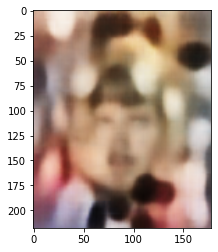

In [0]:
plt.imshow(reconstructed_image)

Vemos que si bien en la imágen obtenida puede vislumbrarse un rostro, deja mucho que desear para un modelo generativo.

Este resultado no satisfactorio se debe a las discontinuidades que pueden aparecer en el espacio latente que aprende el encoder, lo que hace que no todos los puntos pertenecientes a ese espacio sean representaciones válidas para reconsturir imágenes de un rostro.

Estas discontinuidades son las que resuelven los _autoencoder variacionales_ que veremos en la próxima guía.